In [1]:
!pip install -q wordcloud nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [3]:
df = pd.read_csv("student_feedback.csv")
print(df.shape)
df.head()


(1001, 10)


,Unnamed: 0,Student ID,Well versed with the subject,Explains concepts in an understandable way,Use of presentations,Degree of difficulty of assignments,Solves doubts willingly,Structuring of the course,Provides support for students going above and beyond,Course recommendation based on relevance
0,0,340,5,2,7,6,9,2,1,8
1,1,253,6,5,8,6,2,1,2,9
2,2,680,7,7,6,5,4,2,3,1
3,3,806,9,6,7,1,5,9,4,6
4,4,632,8,10,8,4,6,6,9,9


In [4]:
# Drop unnamed columns
df = df.loc[:, ~df.columns.str.contains("Unnamed")]

# Rename if necessary (safe mapping)
rename_map = {
    'Well versed with the subject':'well_versed',
    'Explains concepts in an understandable way':'explains_well',
    'Use of presentations':'presentations',
    'Degree of difficulty of assignments':'assign_difficulty',
    'Solves doubts willingly':'solves_doubts',
    'Structuring of the course':'course_structure',
    'Provides support for students going above and beyond':'support',
    'Course recommendation based on relevance':'recommendation'
}
df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})

df.head()


,Student ID,well_versed,explains_well,presentations,assign_difficulty,solves_doubts,course_structure,support,recommendation
0,340,5,2,7,6,9,2,1,8
1,253,6,5,8,6,2,1,2,9
2,680,7,7,6,5,4,2,3,1
3,806,9,6,7,1,5,9,4,6
4,632,8,10,8,4,6,6,9,9


In [5]:
rating_cols = ['well_versed','explains_well','presentations','assign_difficulty',
               'solves_doubts','course_structure','support','recommendation']

rating_cols = [c for c in rating_cols if c in df.columns]

# Convert to numeric
df[rating_cols] = df[rating_cols].apply(pd.to_numeric, errors='coerce')

# Drop rows with all ratings missing
df = df.dropna(subset=rating_cols, how='all')
df.shape


(1001, 9)

In [6]:
df[rating_cols].describe()


,well_versed,explains_well,presentations,assign_difficulty,solves_doubts,course_structure,support,recommendation
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,7.497502,6.081918,5.942058,5.430569,5.474525,5.636364,5.662338,5.598402
std,1.692998,2.597168,1.415853,2.869046,2.874648,2.920212,2.891690,2.886617
min,5.000000,2.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,6.000000,4.000000,5.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,8.000000,6.000000,6.000000,5.000000,6.000000,6.000000,6.000000,6.000000
75%,9.000000,8.000000,7.000000,8.000000,8.000000,8.000000,8.000000,8.000000
max,10.000000,10.000000,8.000000,10.000000,10.000000,10.000000,10.000000,10.000000


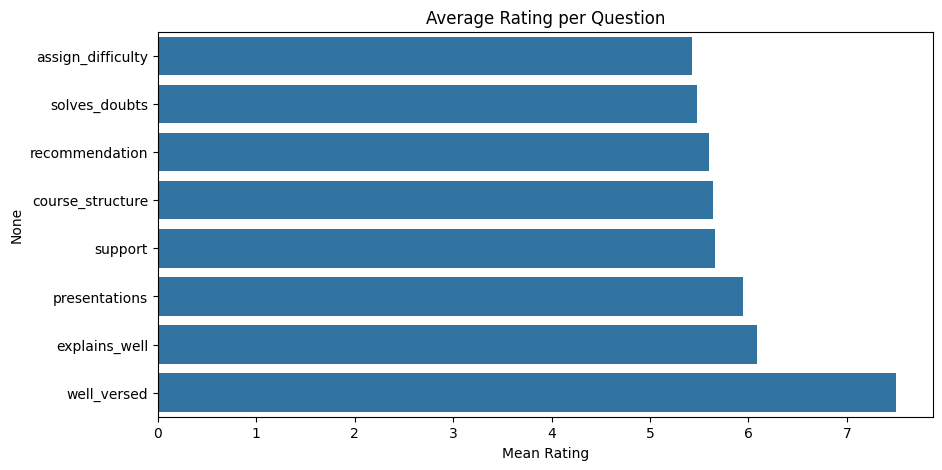

In [7]:
avg = df[rating_cols].mean().sort_values()
plt.figure(figsize=(10,5))
sns.barplot(x=avg.values, y=avg.index)
plt.title("Average Rating per Question")
plt.xlabel("Mean Rating")
plt.show()


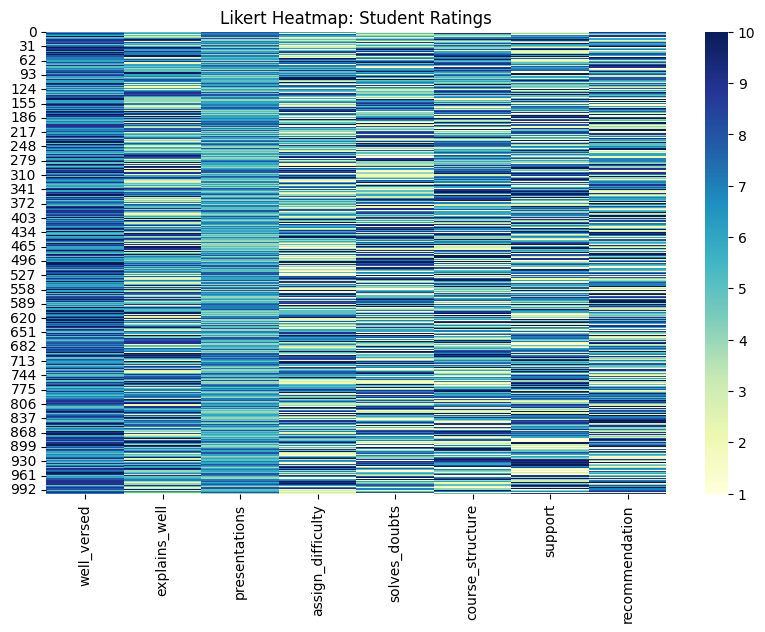

In [8]:
plt.figure(figsize=(10,6))
sns.heatmap(df[rating_cols], cmap="YlGnBu", cbar=True)
plt.title("Likert Heatmap: Student Ratings")
plt.show()


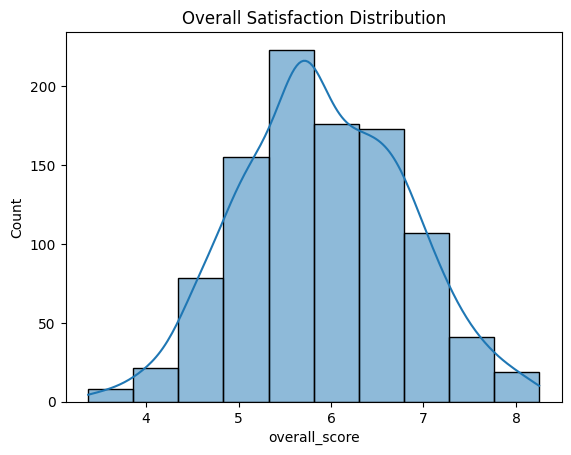

In [9]:
df["overall_score"] = df[rating_cols].mean(axis=1)
sns.histplot(df["overall_score"], kde=True, bins=10)
plt.title("Overall Satisfaction Distribution")
plt.show()


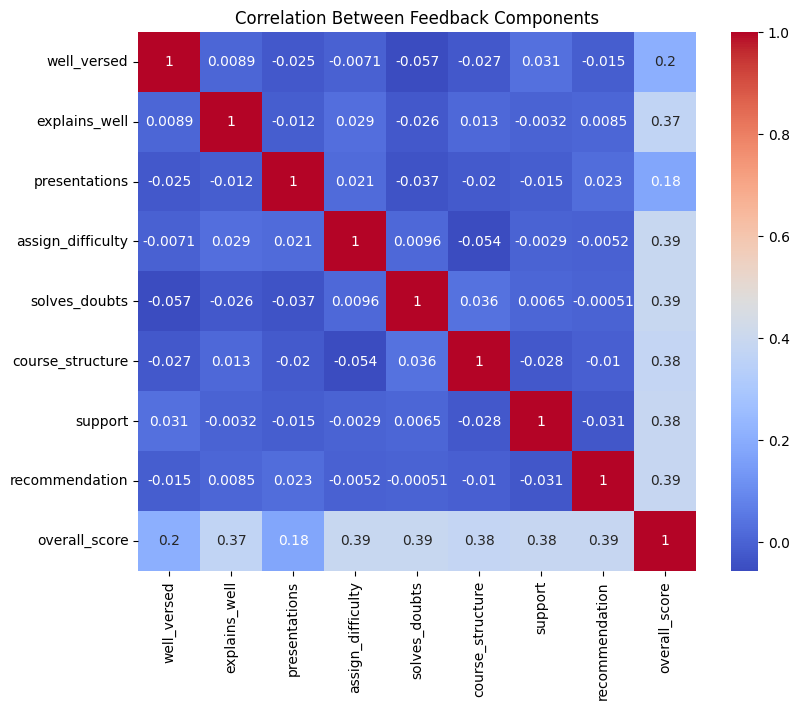

In [10]:
plt.figure(figsize=(9,7))
sns.heatmap(df[rating_cols + ["overall_score"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Feedback Components")
plt.show()


In [11]:
df["satisfaction_level"] = pd.cut(
    df["overall_score"],
    bins=[0,4,7,10],
    labels=["Low","Medium","High"]
)

df["satisfaction_level"].value_counts()


,count
satisfaction_level,
Medium,880
High,105
Low,16


In [28]:
# --- ADDING SYNTHETIC FEEDBACK TEXT ---

# A pool of realistic student event feedback comments
synthetic_comments = [
    "The workshop was really helpful and engaging.",
    "The presentations were boring and too long.",
    "Loved the hands-on activities, very interactive.",
    "The event was well organized and informative.",
    "The assignment difficulty was too high.",
    "The instructor explained concepts clearly.",
    "More real-life examples would have helped.",
    "The pace of the event was too fast.",
    "Enjoyed the session and learned new skills.",
    "Need improvement in course structure.",
    "The support provided was excellent.",
    "The event lacked practical demonstrations.",
    "Slides were good but explanations were rushed.",
    "Overall a very satisfying experience.",
    "The seminar was average, expected more depth."
]

# Repeat and trim comments to match dataset size
df["feedback_text"] = [
    synthetic_comments[i % len(synthetic_comments)]
    for i in range(len(df))
]

# For reference:
print("Synthetic comment column added:")
df[["feedback_text"]].head()


Synthetic comment column added:


,feedback_text
0,The workshop was really helpful and engaging.
1,The presentations were boring and too long.
2,"Loved the hands-on activities, very interactive."
3,The event was well organized and informative.
4,The assignment difficulty was too high.


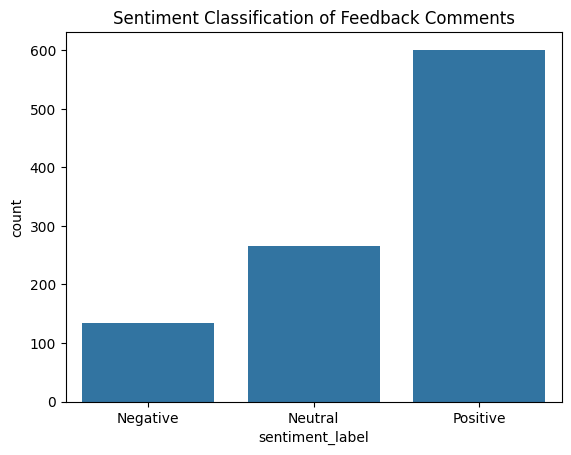

In [36]:
# Sentiment analysis on synthetic feedback_text
comment_col = "feedback_text"

sia = SentimentIntensityAnalyzer()

df["sentiment_score"] = df[comment_col].astype(str).apply(
    lambda x: sia.polarity_scores(x)["compound"]
)

df["sentiment_label"] = pd.cut(
    df["sentiment_score"],
    bins=[-1, -0.05, 0.05, 1],
    labels=["Negative", "Neutral", "Positive"]
)

sns.countplot(x=df["sentiment_label"])
plt.title("Sentiment Classification of Feedback Comments")
plt.show()


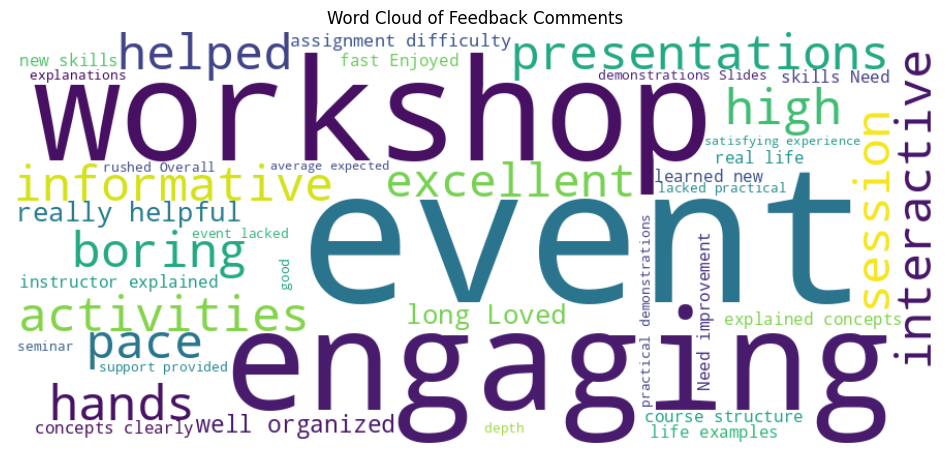

In [37]:
text = " ".join(df["feedback_text"])

wc = WordCloud(width=900, height=400, background_color="white").generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Feedback Comments")
plt.show()


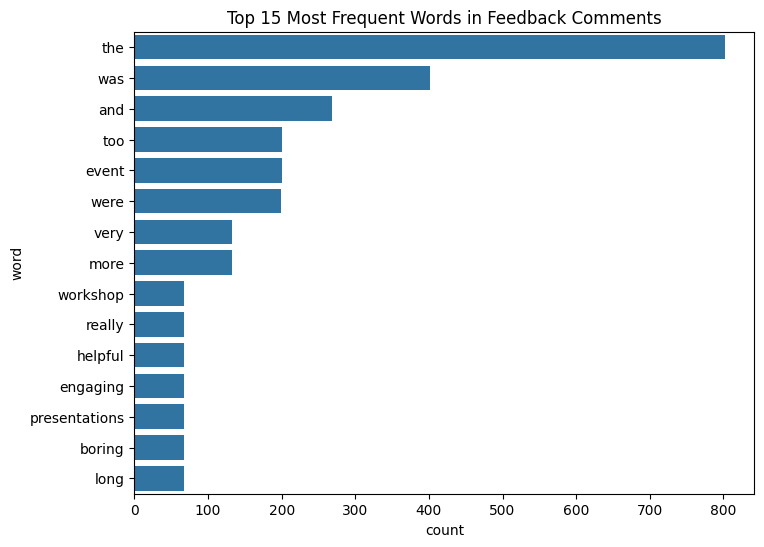

In [38]:
import re
from collections import Counter

all_text = " ".join(df["feedback_text"]).lower()
words = re.findall(r'\b[a-z]{3,}\b', all_text)  # remove very short words

freq = Counter(words).most_common(15)

freq_df = pd.DataFrame(freq, columns=["word", "count"])

plt.figure(figsize=(8,6))
sns.barplot(x="count", y="word", data=freq_df)
plt.title("Top 15 Most Frequent Words in Feedback Comments")
plt.show()


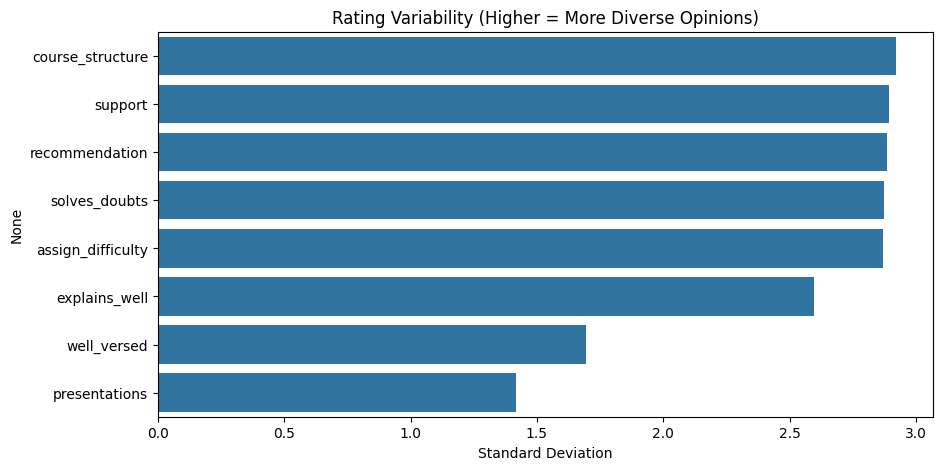

,0
course_structure,2.920212
support,2.891690
recommendation,2.886617
solves_doubts,2.874648
assign_difficulty,2.869046
explains_well,2.597168
well_versed,1.692998
presentations,1.415853


In [16]:
# Standard deviation helps identify inconsistency in ratings
variability = df[rating_cols].std().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=variability.values, y=variability.index)
plt.title("Rating Variability (Higher = More Diverse Opinions)")
plt.xlabel("Standard Deviation")
plt.show()

variability


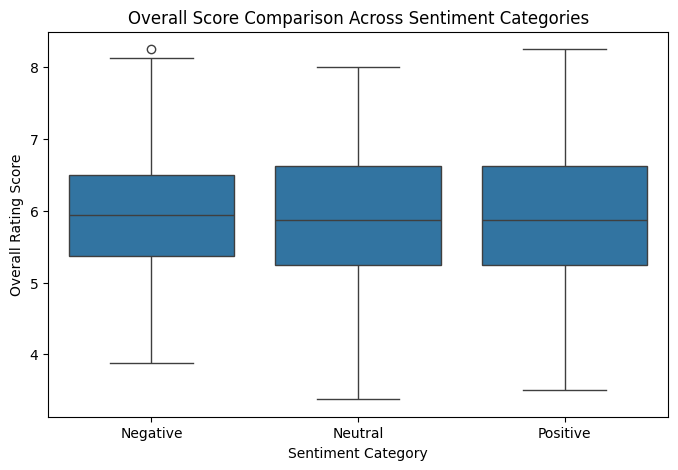

In [32]:
if comment_col:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=df["sentiment_label"], y=df["overall_score"])
    plt.title("Overall Score Comparison Across Sentiment Categories")
    plt.xlabel("Sentiment Category")
    plt.ylabel("Overall Rating Score")
    plt.show()


In [33]:
if comment_col:
    positive_comments = df[df["sentiment_label"]=="Positive"][comment_col].head(5)
    negative_comments = df[df["sentiment_label"]=="Negative"][comment_col].head(5)

    print("🌟 Top Positive Feedback:")
    for c in positive_comments:
        print("-", c)

    print("\n⚠️ Top Negative Feedback:")
    for c in negative_comments:
        print("-", c)


🌟 Top Positive Feedback:
- The workshop was really helpful and engaging.
- Loved the hands-on activities, very interactive.
- The event was well organized and informative.
- The instructor explained concepts clearly.
- Enjoyed the session and learned new skills.

⚠️ Top Negative Feedback:
- The presentations were boring and too long.
- The assignment difficulty was too high.
- The presentations were boring and too long.
- The assignment difficulty was too high.
- The presentations were boring and too long.


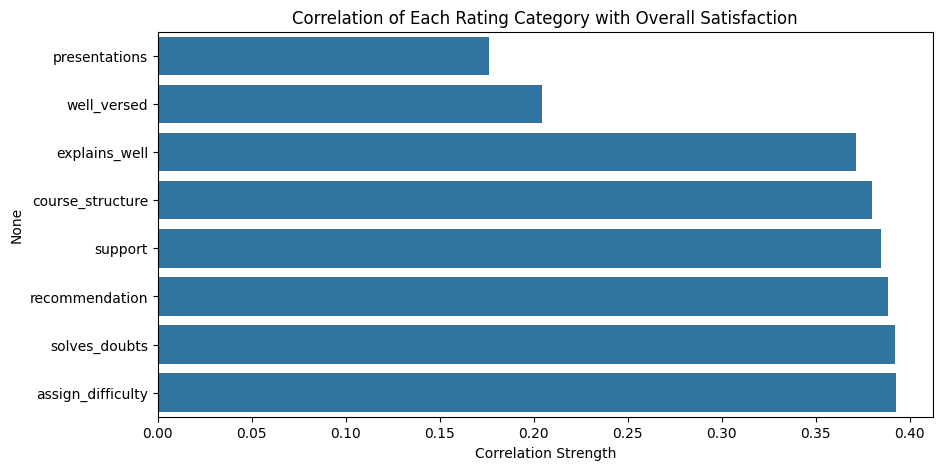

,overall_score
presentations,0.176207
well_versed,0.204551
explains_well,0.371296
course_structure,0.379754
support,0.384881
recommendation,0.388351
solves_doubts,0.392453
assign_difficulty,0.392695


In [20]:
corr_with_overall = df[rating_cols + ["overall_score"]].corr()["overall_score"].drop("overall_score")
corr_with_overall = corr_with_overall.sort_values()

plt.figure(figsize=(10,5))
sns.barplot(x=corr_with_overall.values, y=corr_with_overall.index)
plt.title("Correlation of Each Rating Category with Overall Satisfaction")
plt.xlabel("Correlation Strength")
plt.show()

corr_with_overall


/tmp/ipython-input-1362121336.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segmented_means = df.groupby("satisfaction_level")[rating_cols].mean()


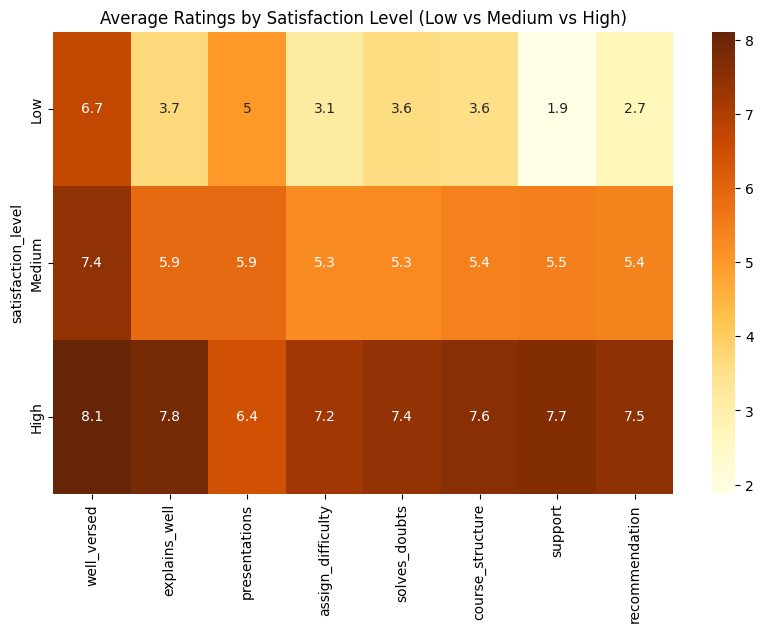

,well_versed,explains_well,presentations,assign_difficulty,solves_doubts,course_structure,support,recommendation
satisfaction_level,,,,,,,,
Low,6.687500,3.687500,5.000000,3.125000,3.625000,3.562500,1.875000,2.687500
Medium,7.438636,5.914773,5.900000,5.259091,5.277273,5.444318,5.492045,5.423864
High,8.114286,7.847619,6.438095,7.219048,7.409524,7.561905,7.666667,7.504762


In [21]:
segmented_means = df.groupby("satisfaction_level")[rating_cols].mean()

plt.figure(figsize=(10,6))
sns.heatmap(segmented_means, annot=True, cmap="YlOrBr")
plt.title("Average Ratings by Satisfaction Level (Low vs Medium vs High)")
plt.show()

segmented_means


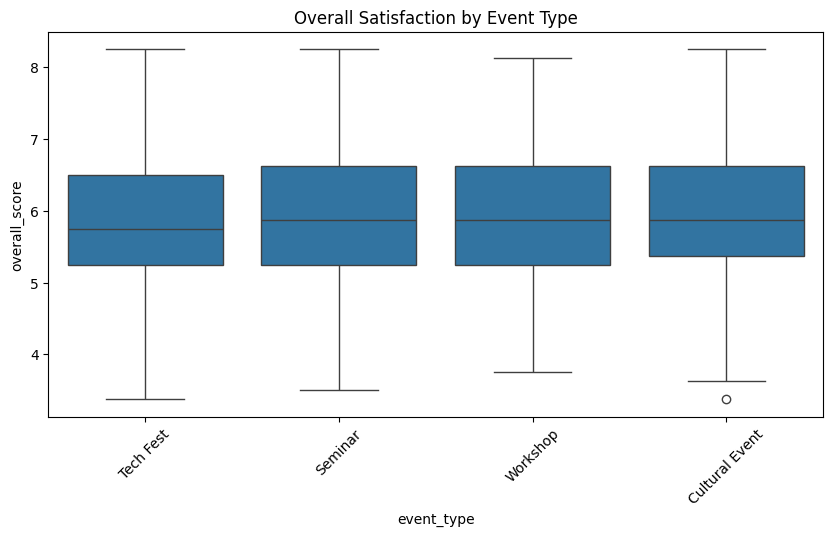

In [40]:
import numpy as np

# Synthetic event categories
event_types = ["Workshop", "Tech Fest", "Seminar", "Cultural Event"]

# Assign random event types to each row
df["event_type"] = np.random.choice(event_types, size=len(df))

df.head()
plt.figure(figsize=(10,5))
sns.boxplot(x=df["event_type"], y=df["overall_score"])
plt.xticks(rotation=45)
plt.title("Overall Satisfaction by Event Type")
plt.show()


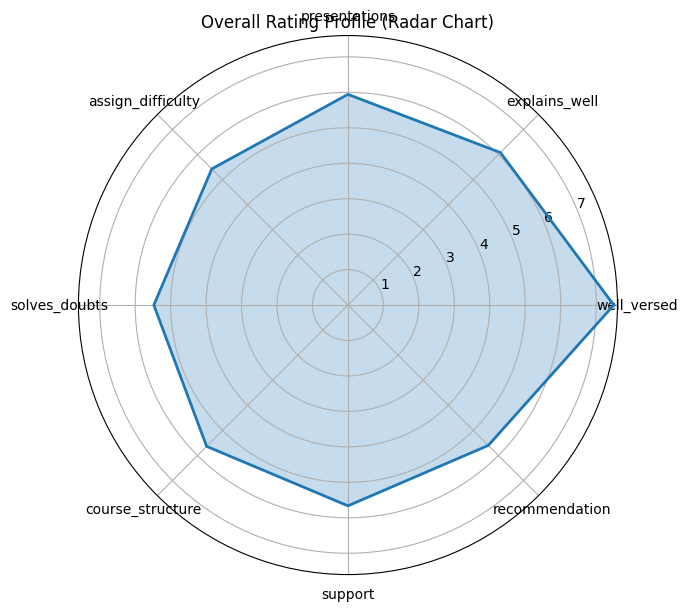

In [23]:
# Compute means
means = df[rating_cols].mean()

# Radar chart setup
labels = means.index
stats = means.values
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
stats = np.concatenate((stats, [stats[0]]))
angles = angles + [angles[0]]

plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True)
ax.plot(angles, stats, linewidth=2)
ax.fill(angles, stats, alpha=0.25)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.title("Overall Rating Profile (Radar Chart)")
plt.show()


In [41]:
df.head()


,Student ID,well_versed,explains_well,presentations,assign_difficulty,solves_doubts,course_structure,support,recommendation,overall_score,satisfaction_level,feedback_text,sentiment_score,sentiment_label,event_type
0,340,5,2,7,6,9,2,1,8,5.000,Medium,The workshop was really helpful and engaging.,0.6962,Positive,Tech Fest
1,253,6,5,8,6,2,1,2,9,4.875,Medium,The presentations were boring and too long.,-0.3182,Negative,Seminar
2,680,7,7,6,5,4,2,3,1,4.375,Medium,"Loved the hands-on activities, very interactive.",0.5994,Positive,Workshop
3,806,9,6,7,1,5,9,4,6,5.875,Medium,The event was well organized and informative.,0.2732,Positive,Workshop
4,632,8,10,8,4,6,6,9,9,7.500,High,The assignment difficulty was too high.,-0.3400,Negative,Seminar
